In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df = pd.read_csv("training.csv")
X = np.zeros((df.shape[0], df.shape[1]-1))
X.shape
for key, value in df.iterrows():
  X[key,0] = int(value[0],16)
  X[key,1] = int(value[1],16)

y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.autograd import Variable

tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.LongTensor(y_train)

train_set = TensorDataset(tensor_x,tensor_y) # create your datset
train_loader = DataLoader(train_set) # create your dataloader

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_set = TensorDataset(tensor_x,tensor_y) # create your datset
test_loader = DataLoader(test_set) # create your dataloader

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):
    def __init__(self, num_features, num_hidden):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, num_hidden)
        self.fc2 = nn.Linear(num_hidden, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

fcn = Net(2, 10)

In [9]:
# create a stochastic gradient descent optimizer
learning_rate = 0.005

optimizer = optim.SGD(fcn.parameters(), lr=learning_rate, momentum=0.9)

# create a loss function
criterion = nn.NLLLoss() # try? CrossEntropyLoss

In [12]:
epochs = 5

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        net_out = fcn(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
          print('Train Epoch: ', epoch) 
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #         epoch, batch_idx * len(data), len(train_loader.dataset),
            #                100. * batch_idx / len(train_loader), loss.data[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch:  0
Train Epoch:  0
Train Epoch:  0
Train Epoch:  0
Train Epoch:  0
Train Epoch:  0
Train Epoch:  1
Train Epoch:  1
Train Epoch:  1
Train Epoch:  1
Train Epoch:  1
Train Epoch:  1
Train Epoch:  2
Train Epoch:  2
Train Epoch:  2
Train Epoch:  2
Train Epoch:  2
Train Epoch:  2
Train Epoch:  3
Train Epoch:  3
Train Epoch:  3
Train Epoch:  3
Train Epoch:  3
Train Epoch:  3
Train Epoch:  4
Train Epoch:  4
Train Epoch:  4
Train Epoch:  4
Train Epoch:  4
Train Epoch:  4


In [15]:
# run a test loop
test_loss = 0
correct = 0
y_pred = []
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    net_out = fcn(data)
    # sum up batch loss
    # test_loss += criterion(net_out, target).data[0]

    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    y_pred.append(int(pred))
    correct += pred.eq(target.data).sum()
# test_loss /= len(test_loader.dataset)
# print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

correct / len(test_loader.dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor(0.6042)

In [ ]:
y_pred

[Text(42.0, 0.5, 'True Value'), Text(0.5, 42.0, 'Predicted Value')]

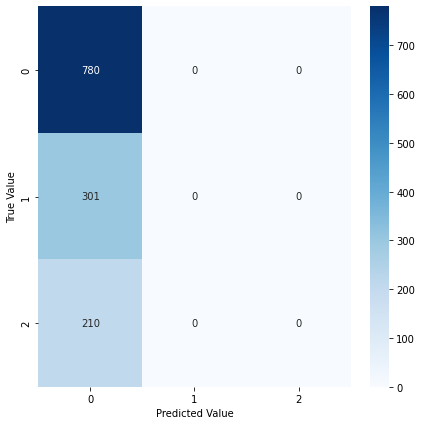

In [27]:
import sklearn
# from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix, index = [0,1,2], columns = [0,1,2])
plt.figure(figsize = (7,7))
s = sn.heatmap(df_cm, annot=True, fmt='g',cmap='Blues')
s.set(xlabel='Predicted Value', ylabel='True Value')
# tensor(0.6139)



## TODO: LSTM


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable 

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [ ]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 3 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 